## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt

import json
import os.path
import gc

MODEL_FILE_NAME = 'model.txt'

def transform_isrc_to_year(isrc):
    if type(isrc) != str:
        return np.nan
    # this year 2017
    suffix = int(isrc[5:7])
    return 1900 + suffix if suffix > 17 else 2000 + suffix

## Read CSV data 

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')
members_df = pd.read_csv('data/members.csv')

## Pre-process members.csv

In [3]:
def parse_str_to_date(date_str):
    # [format] yyyymmdd
    date_str = str(date_str)
    assert(isinstance(date_str, str))
    assert(len(date_str) == 8)
    
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:])
    
    return dt.date(year, month, day)
    
           
def transform_two_dates_to_days(row):
    start = parse_str_to_date(row['registration_init_time'])
    end = parse_str_to_date(row['expiration_date'])
    delta = end - start
    
    return delta.days


members_df['membership_days'] = members_df.apply(transform_two_dates_to_days, axis=1)
members_df.drop(['registration_init_time', 'expiration_date', 'bd', 'gender'], axis=1, inplace=True)
members_df

,msno,city,registered_via,membership_days
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,7,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,7,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,4,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,9,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,4,138
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,9,1921
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,4,3
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,7,609
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,7,2454
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,7,482


In [4]:
song_extra_info_df['song_year'] = song_extra_info_df['isrc'].apply(transform_isrc_to_year)
song_extra_info_df.drop(['name', 'isrc'], axis=1, inplace=True)

songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

del members_df, song_extra_info_df
gc.collect()

for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')
for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

x = train_df.drop(['target'], axis=1)
y = train_df['target'].values

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id'].values

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

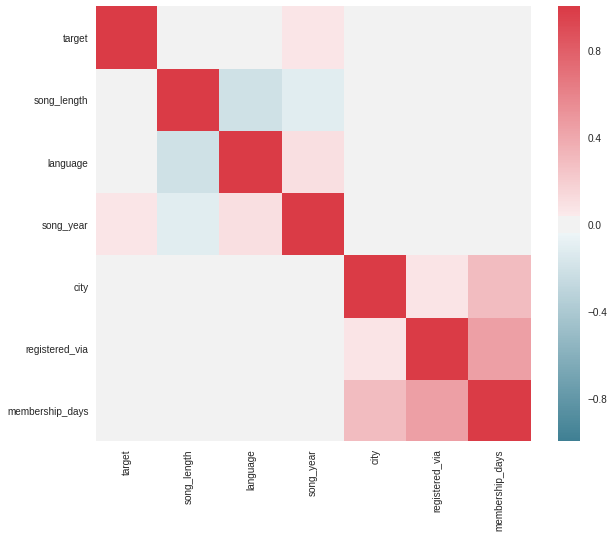

In [5]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
sns.plt.show()

In [6]:
train_set = lgb.Dataset(x, y)
valid_set = [train_set]

params = dict({
    'learning_rate': 0.1,
    'application': 'binary',
    'min_data_in_leaf': 4,
    'max_depth': 10,
    'num_leaves': 2 ** 10,
    'verbosity': 0,
    'metric': 'auc'
})

model = lgb.train(params, train_set=train_set, valid_sets=valid_set, num_boost_round=100)
y_test = model.predict(x_test)

[1]	training's auc: 0.680317
[2]	training's auc: 0.69032
[3]	training's auc: 0.693165
[4]	training's auc: 0.701419
[5]	training's auc: 0.704826
[6]	training's auc: 0.706993
[7]	training's auc: 0.71037
[8]	training's auc: 0.712311
[9]	training's auc: 0.714709
[10]	training's auc: 0.716913
[11]	training's auc: 0.718817
[12]	training's auc: 0.72046
[13]	training's auc: 0.722734
[14]	training's auc: 0.724098
[15]	training's auc: 0.72549
[16]	training's auc: 0.726825
[17]	training's auc: 0.727367
[18]	training's auc: 0.729704
[19]	training's auc: 0.730474
[20]	training's auc: 0.731779
[21]	training's auc: 0.732607
[22]	training's auc: 0.733869
[23]	training's auc: 0.734709
[24]	training's auc: 0.735675
[25]	training's auc: 0.736433
[26]	training's auc: 0.736825
[27]	training's auc: 0.737494
[28]	training's auc: 0.738306
[29]	training's auc: 0.738735
[30]	training's auc: 0.739324
[31]	training's auc: 0.740637
[32]	training's auc: 0.74136
[33]	training's auc: 0.742344
[34]	training's auc: 0.7

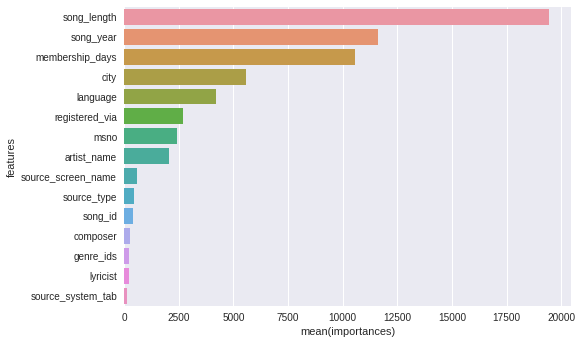

In [7]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

sns.barplot(x = plot_df.importances, y = plot_df.features)
sns.plt.show()

In [9]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
submission_df.to_csv('data/submission.csv', index=False)
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 39.0 MB
